# Machine Translation

In [1]:
import re
import os
import numpy as np
import jieba
import collections

import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping,ReduceLROnPlateau
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from sklearn.model_selection import train_test_split

In [2]:
# Verify  GPU
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 5378076843820779514
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 15862523495
locality {
  bus_id: 2
  numa_node: 1
  links {
  }
}
incarnation: 5115458866657065834
physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:87:00.0, compute capability: 6.0"
]


## 1. Data Preparation
### 1.1 Load Data

In [3]:
# Load English data
print("Loading data...")

def load_data(path):
    """
    Load dataset
    """
    input_file = os.path.join(path)
    with open(input_file, "r") as f:
        data = f.read()

    return data.split('\n')

en_sentences = load_data('data/train.txt.en')

# Load Chinese data
cn_sentences = load_data('data/train.txt.zh')

Loading data...


In [4]:
print('Dataset Loaded')
print("lenght of Source sentences:", len(en_sentences))
print("Source sample: ", en_sentences[0])

print("lenght of Target sentences:", len(en_sentences))
print("Target sample: ", cn_sentences[0].replace(" ",""))

Dataset Loaded
lenght of Source sentences: 209941
Source sample:  This is Bill Lange . I 'm Dave Gallo .
lenght of Target sentences: 209941
Target sample:  大卫.盖罗：这位是比尔.兰格，我是大卫.盖罗。


### 1.2 Filter out sentences with length more than 50

In [5]:
en_list = []
cn_list = []

#===========input parameter ========================
max_len = 50
#max_vocab_size = 50000
en_vocab_size = 50000 
cn_vocab_size = 10000
max_rows = 200000
name = "Bidirectional"
#===================================================

def clean_eng(x):
    x = x.lower()
    x = re.sub('[!?]','',x)
    return x

def clean_chn(x):
    x = re.sub('[!?！？\n]','',x)
    x = jieba.cut(x)
    return ' '.join(x)

In [6]:
for i in range(len(en_sentences)):
    # Add <s> start and <e> end to the each target sentence  
    en_sentences[i] = clean_eng(en_sentences[i])
    cn_sentences[i] = "<s> " + clean_chn(cn_sentences[i].replace(" ","")) + " <e>"
    
    if len(en_sentences[i].split()) <= max_len and len(cn_sentences[i].split()) <= max_len:
        en_list.append(en_sentences[i])
        cn_list.append(cn_sentences[i])
        
print("lenght of Source:", len(en_list))
print("Source: ", en_list[0])

print("lenght of Target sentences:", len(cn_list))
print("Target: ", cn_list[0])

Building prefix dict from the default dictionary ...
Loading model from cache /tmp/jieba.cache
Loading model cost 0.758 seconds.
Prefix dict has been built succesfully.


lenght of Source: 200884
Source:  this is bill lange . i 'm dave gallo .
lenght of Target sentences: 200884
Target:  <s> 大卫 . 盖罗 ： 这位 是 比尔 . 兰格 ， 我 是 大卫 . 盖罗 。 <e>


In [7]:
for i in range(5):
    print(en_list[i])
    print(cn_list[i])

this is bill lange . i 'm dave gallo .
<s> 大卫 . 盖罗 ： 这位 是 比尔 . 兰格 ， 我 是 大卫 . 盖罗 。 <e>
and we 're going to tell you some stories from the sea here in video .
<s> 我们 将 用 一些 影片 来 讲述 一些 深海 里 的 故事 。 <e>
we 've got some of the most incredible video of titanic that 's ever been seen , and we 're not going to show you any of it .
<s> 我们 这有 不少 精彩 的 泰坦尼克 的 影片 ， 可惜 您 今天 看不到 。 <e>
the truth of the matter is that the titanic -- even though it 's breaking all sorts of box office records -- it 's not the most exciting story from the sea .
<s> 泰坦尼克号 是 拿 了 不少 票房 冠军 但 事实上 它 并 不是 关于 海洋 的 最 刺激 的 故事 。 <e>
and the problem , i think , is that we take the ocean for granted .
<s> 原因 在于 我们 一直 没 把 海洋 当 回事儿 。 <e>


### 1.3 Split sentence into words

In [8]:
en_words_counter = collections.Counter([word for sentence in en_list for word in sentence.split()])
cn_words_counter = collections.Counter([word for sentence in cn_list for word in sentence.split()])

print('{} English words.'.format(len([word for sentence in en_sentences for word in sentence.split()])))
print('{} unique English words.'.format(len(en_words_counter)))
print('20 Most common words in the English dataset:')
print('"' + '" "'.join(list(zip(*en_words_counter.most_common(20)))[0]) + '"')
print("---------------------------------------------------------------------------------------------------------------")
print('{} Chinese words.'.format(len([word for sentence in cn_sentences for word in sentence.split()])))
print('{} unique Chinese words.'.format(len(cn_words_counter)))
print('20 Most common words in the Chinese dataset:')
print('"' + '" "'.join(list(zip(*cn_words_counter.most_common(20)))[0]) + '"')

4250820 English words.
55163 unique English words.
20 Most common words in the English dataset:
"," "." "the" "and" "to" "of" "a" "that" "i" "it" "in" "you" "we" "is" "'s" "this" "so" """ "they" "was"
---------------------------------------------------------------------------------------------------------------
4180600 Chinese words.
82572 unique Chinese words.
20 Most common words in the Chinese dataset:
"的" "<s>" "<e>" "，" "。" "我" "我们" "是" "在" "了" "你" """ "一个" "这" "有" "他们" "和" "就" "它" "这个"


### 1.4 Split data into training and testing set

In [9]:
### Split the preccessed data into training and test sets using Sklearn ###
en_train, en_test, cn_train, cn_test = train_test_split(np.array(en_list), 
                                                        np.array(cn_list), 
                                                        test_size=0.1, 
                                                        random_state=42,
                                                        shuffle = True)

In [10]:
print("en_train.shape: ", en_train.shape)
print("en_test.shape: ", en_test.shape)
print("cn_train.shape: ", cn_train.shape)
print("cn_test.shape: ", cn_test.shape)

en_train.shape:  (180795,)
en_test.shape:  (20089,)
cn_train.shape:  (180795,)
cn_test.shape:  (20089,)


## 2. Tokenize and Padding

### 2.1 Tokenize English and Chinese sentences

In [11]:
def tokenize(texts, maxlen, num_words):
    tokenizer = Tokenizer(filters='',num_words = num_words, oov_token = '<unk>')
    tokenizer.fit_on_texts(texts)
    vocab_size = len(tokenizer.index_word) + 1
    max_len = max(list(map(lambda i: len(i.split()), texts)))
    max_len =  min(max_len, maxlen)
    vocab_size = min(vocab_size, num_words)

    seqs = tokenizer.texts_to_sequences(texts)
    padded_seqs = pad_sequences(seqs, max_len, padding='post')
    return tokenizer, vocab_size, max_len, padded_seqs

In [12]:
# Create English tokeninzer for training set
src_tokenizer, src_vocab_size, src_max_len, en_input_seq = \
tokenize(en_train, max_len, en_vocab_size)

In [13]:
print("src_tokenizer.index_word: ", len(src_tokenizer.index_word))
print("src_vocab_size: ", src_vocab_size)
print("src_max_len: ", src_max_len)
print("en_input_seq.shape: ", en_input_seq.shape)
print("en_input_seq: ", en_input_seq)

src_tokenizer.index_word:  52939
src_vocab_size:  50000
src_max_len:  50
en_input_seq.shape:  (180795, 50)
en_input_seq:  [[   5    8  132 ...    0    0    0]
 [  10  222   11 ...    0    0    0]
 [ 340    2   14 ...    0    0    0]
 ...
 [  48 3818    9 ...    3    0    0]
 [   5   17   15 ...    0    0    0]
 [  26   35   20 ...    0    0    0]]


In [14]:
# Create Chinese tokeninzer
tar_tokenizer, tar_vocab_size, tar_max_len, de_input_seq = \
tokenize(cn_train, max_len, cn_vocab_size)

In [15]:
print("tar_tokenizer length: ", len(tar_tokenizer.index_word))
print("tar_tokenizer.index_word: ", tar_tokenizer.index_word[10])
print("tar_vocab_size: ", tar_vocab_size)
print("tar_max_len: ", tar_max_len)
print("de_input_seq.shape: ", de_input_seq.shape)
print("de_input_seq: ", de_input_seq) 

tar_tokenizer length:  78590
tar_tokenizer.index_word:  在
tar_vocab_size:  10000
tar_max_len:  50
de_input_seq.shape:  (180795, 50)
de_input_seq:  [[   3  102  878 ...    0    0    0]
 [   3    7   10 ...    4    0    0]
 [   3  658  133 ...    0    0    0]
 ...
 [   3   24  108 ... 1243    6    4]
 [   3   15   25 ...    0    0    0]
 [   3   40   66 ...    0    0    0]]


In [16]:
print(tar_tokenizer.index_word[12])

你


In [17]:
de_target_seq = de_input_seq[:,1:]
print("de_target_seq.shape: ", de_target_seq.shape)
print("de_target_seq: ", de_target_seq)

de_target_seq.shape:  (180795, 49)
de_target_seq:  [[ 102  878   22 ...    0    0    0]
 [   7   10  212 ...    4    0    0]
 [ 658  133   35 ...    0    0    0]
 ...
 [  24  108 3411 ... 1243    6    4]
 [  15   25  277 ...    0    0    0]
 [  40   66   68 ...    0    0    0]]


In [18]:
de_input_seq = de_input_seq[:,:-1]

print("de_input_seq.shape: ", de_input_seq.shape)
print("de_input_seq: ", de_input_seq)

de_input_seq.shape:  (180795, 49)
de_input_seq:  [[   3  102  878 ...    0    0    0]
 [   3    7   10 ...   13    4    0]
 [   3  658  133 ...    0    0    0]
 ...
 [   3   24  108 ...  294 1243    6]
 [   3   15   25 ...    0    0    0]
 [   3   40   66 ...    0    0    0]]


In [19]:
print('max len: ' + str((src_max_len, tar_max_len)))
print('vocab size: ' + str((src_vocab_size, tar_vocab_size)))

max len: (50, 50)
vocab size: (50000, 10000)


In [20]:
print(de_target_seq.shape)
print(tar_vocab_size)

del en_sentences
del cn_sentences

(180795, 49)
10000


In [21]:
de_target_matrix = to_categorical(de_target_seq, tar_vocab_size)

In [22]:
print(de_target_matrix.shape)

(180795, 49, 10000)


## 3. Callback Functions

### 3.1 Reduce learning rate when a metric has stopped improving
Now, we start defining callback functions...

In [23]:
lr_reducer = ReduceLROnPlateau(monitor='val_loss', 
                               factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=2, 
                               min_lr=1e-6)

### 3.2 Model checkpoint

In [24]:
save_dir = os.getcwd()
weight_path = "./weight/" + name + ".h5"

# model.save(model_path)
print('Model Path at %s ' % weight_path)

# Save the model after every epoch if model improves
model_checkpoint = ModelCheckpoint(weight_path, 
                                   monitor="val_acc", 
                                   save_best_only=True,
                                   save_weights_only=True, 
                                   verbose=1)

Model Path at ./weight/Bidirectional.h5 


### 3.3 Early Stop

In [25]:
early_stopping = EarlyStopping(monitor='val_loss', 
                               patience=4, 
                               verbose=1)

### 3.4 Monitor Learning Rate for every epoch

In [26]:
history_lr = []  # Variable to store leraning rate history

class MonitorLR(tf.keras.callbacks.Callback):   
    def on_epoch_end(self, epoch, logs=None):
        print("\n")
        print("Learning Rate:", K.eval(self.model.optimizer.lr))
        print("\n")
        history_lr.append(K.eval(self.model.optimizer.lr))
              
monitorLR = MonitorLR()

### 3.5 Callback function
To be applied at given stages of the training procedure.

In [27]:
callbacks=[lr_reducer,
           monitorLR, 
           model_checkpoint,
           early_stopping]

## 4. Model
### 4.1 Build Model

In [28]:
print("Now, creating model...")
#======== model paramters =======
latent_dim = 512
#======== train paramters =======
#epochs = 100
epochs = 30
batch_size = 256
#================================

Now, creating model...


### 4.2 Encoder model

In [29]:
print("Creating Encoder Model...")

# encoder model
enc_input = Input((None,), name = 'encoder_input_seq')
enc_embed = Embedding(src_vocab_size + 1, latent_dim, name = 'encoder_embed')
encoder = Bidirectional(LSTM(latent_dim, return_state=True, name = 'encoder'))
enc_z, enc_state_h_f, enc_state_c_f, enc_state_h_b, enc_state_c_b = encoder(enc_embed(enc_input))
enc_state_h = Concatenate()([enc_state_h_f, enc_state_h_b])
enc_state_c = Concatenate()([enc_state_c_f, enc_state_c_b])
enc_states = [enc_state_h, enc_state_c]
enc_model = Model(enc_input, enc_states)

print("enc_model: ", enc_model.summary())

Creating Encoder Model...
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input_seq (InputLayer)  (None, None)         0                                            
__________________________________________________________________________________________________
encoder_embed (Embedding)       (None, None, 512)    25600512    encoder_input_seq[0][0]          
__________________________________________________________________________________________________
bidirectional (Bidirectional)   [(None, 1024), (None 4198400     encoder_embed[0][0]              
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 1024)         0           bidirectional[0][1]              
                                                                 bidirectional[0][3

### 4.3 Decoder model

In [30]:
print("Creating Decoder Model...")

# decoder model
dec_input = Input((None,), name = 'decoder_input_seq')
dec_state_h_input = Input((latent_dim * 2,), name = 'decoder_input_state_h')
dec_state_c_input = Input((latent_dim * 2,), name = 'decoder_input_state_c')
dec_states_input = [dec_state_h_input, dec_state_c_input]

dec_embed = Embedding(tar_vocab_size + 1, latent_dim, name = 'decoder_embed')
decoder = LSTM(latent_dim * 2, return_state=True, return_sequences=True, name = 'decoder')
dec_fc = TimeDistributed(Dense(tar_vocab_size, activation='softmax'), name = 'decoder_output')

dec_z, dec_state_h, dec_state_c = decoder(dec_embed(dec_input), initial_state = dec_states_input)
dec_states_output = [dec_state_h, dec_state_c]
dec_output = dec_fc(dec_z)

dec_model = Model([dec_input]+dec_states_input, [dec_output]+dec_states_output)

print("dec_model: ", dec_model.summary())

Creating Decoder Model...
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
decoder_input_seq (InputLayer)  (None, None)         0                                            
__________________________________________________________________________________________________
decoder_embed (Embedding)       (None, None, 512)    5120512     decoder_input_seq[0][0]          
__________________________________________________________________________________________________
decoder_input_state_h (InputLay (None, 1024)         0                                            
__________________________________________________________________________________________________
decoder_input_state_c (InputLay (None, 1024)         0                                            
___________________________________________________________________________________

### 4.4 Encoder_decoder training model

In [31]:
print("Creating Encoder_decoder Model...")

# encoder_decoder training model
tar_logit, _, _ = decoder(dec_embed(dec_input), initial_state= enc_states)
tar_output = dec_fc(tar_logit)

enc_dec_model = Model([enc_input, dec_input], tar_output)


if not os.path.exists('./weight/'):
    os.mkdir('./weight/')
    
try:
    enc_dec_model.load_weights(weight_path)
    print('load from previous model')
except:
    print('train a new model')    

optimizer = tf.keras.optimizers.Adam(lr = 0.001,
                                     beta_1=0.9, 
                                     beta_2=0.999, 
                                     amsgrad=False)

enc_dec_model.compile(loss = 'categorical_crossentropy',
                      optimizer= optimizer,
                      metrics=['accuracy'])

#  model summary
enc_dec_model.summary()

print("Done")

Creating Encoder_decoder Model...
train a new model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input_seq (InputLayer)  (None, None)         0                                            
__________________________________________________________________________________________________
encoder_embed (Embedding)       (None, None, 512)    25600512    encoder_input_seq[0][0]          
__________________________________________________________________________________________________
decoder_input_seq (InputLayer)  (None, None)         0                                            
__________________________________________________________________________________________________
bidirectional (Bidirectional)   [(None, 1024), (None 4198400     encoder_embed[0][0]              
_________________________________________________________

### 4.5 Model Structure

In [32]:
# Save model as image
plot_model(enc_dec_model, 
           "./images/" + name + ".png", 
           show_shapes=True, 
           show_layer_names=True)

print("Done!")

Done!


Populating the interactive namespace from numpy and matplotlib


/root/miniconda3/envs/new/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['multiply', 'subtract', 'average', 'concatenate', 'dot', 'maximum', 'add', 'minimum']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


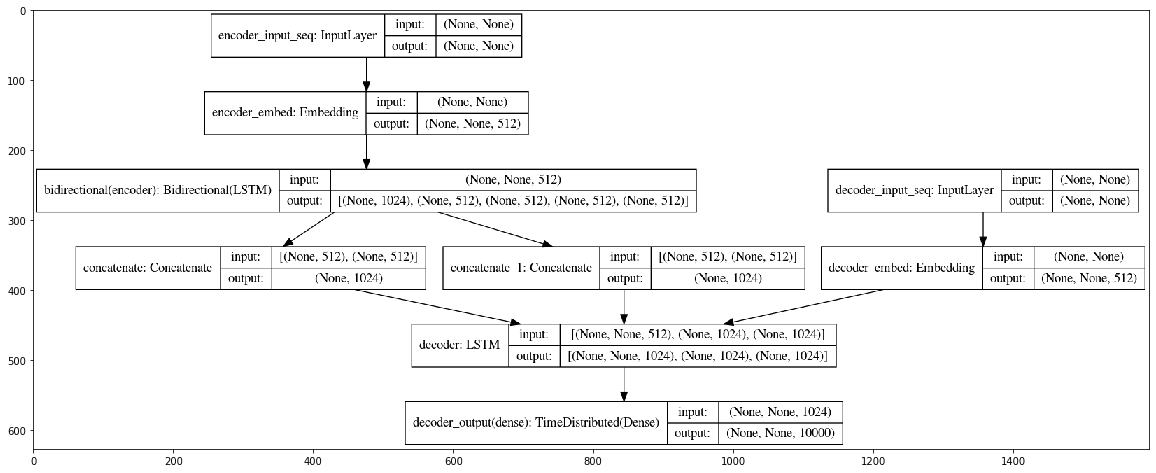

In [33]:
%pylab inline
import matplotlib.image as mpimg
img=mpimg.imread("./images/" + name + ".png")

plt.figure(figsize = (20,15))
imgplot = plt.imshow(img)
plt.show()

### 4.6 Fit Model

In [34]:
history = enc_dec_model.fit([en_input_seq, de_input_seq], 
                            de_target_matrix,
                            batch_size=batch_size,
                            epochs=epochs, 
                            shuffle = True,
                            callbacks = callbacks,
                            validation_split = 0.1)

/root/miniconda3/envs/new/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 162715 samples, validate on 18080 samples
Epoch 1/30
162560/162715 [============================>.] - ETA: 0s - loss: 2.0700 - acc: 0.7026

Learning Rate: 0.001



Epoch 00001: val_acc improved from -inf to 0.72817, saving model to ./weight/Bidirectional.h5
162715/162715 [==============================] - 806s 5ms/step - loss: 2.0696 - acc: 0.7027 - val_loss: 1.7813 - val_acc: 0.7282
Epoch 2/30
162560/162715 [============================>.] - ETA: 0s - loss: 1.6564 - acc: 0.7398

Learning Rate: 0.001



Epoch 00002: val_acc improved from 0.72817 to 0.74491, saving model to ./weight/Bidirectional.h5
162715/162715 [==============================] - 703s 4ms/step - loss: 1.6563 - acc: 0.7398 - val_loss: 1.5801 - val_acc: 0.7449
Epoch 3/30
162560/162715 [============================>.] - ETA: 0s - loss: 1.4793 - acc: 0.7529

Learning Rate: 0.001



Epoch 00003: val_acc improved from 0.74491 to 0.75313, saving model to ./weight/Bidirectional.h5
162715/162715 [======================

## 5. Evaluate Model
### 5.1 Load Weight

In [35]:
print("Now, we start evaluating the model...")
# Load weight
print(weight_path)
enc_dec_model.load_weights(weight_path)
print("Weights were loaded!")

Now, we start evaluating the model...
./weight/Bidirectional.h5
Weights were loaded!


### 5.2 Score training set

In [36]:
scores_train = enc_dec_model.evaluate([en_input_seq, de_input_seq], 
                                       de_target_matrix,
                                       verbose=1)

print('Train loss:', scores_train[0])
print('Train accuracy:', scores_train[1])

180795/180795 [==============================] - 1039s 6ms/step
Train loss: 1.0651409131822116
Train accuracy: 0.7869692303045169


### 5.3 Score test data

In [37]:
# Tokenize and pad testing set
en_seqs = src_tokenizer.texts_to_sequences(en_test)
en_input_seq_test = pad_sequences(en_seqs, src_max_len, padding='post')

cn_seqs = tar_tokenizer.texts_to_sequences(cn_test)
de_input_seq_test = pad_sequences(cn_seqs, tar_max_len, padding='post')

de_target_seq_test = de_input_seq_test[:,1:]
de_input_seq_test = de_input_seq_test[:,:-1]

de_target_matrix_test = to_categorical(de_target_seq_test, tar_vocab_size)

In [38]:
print('en_input_seq_test.shape:', en_input_seq_test.shape)
print('de_input_seq_test.shape:', de_input_seq_test.shape)
print('de_target_seq_test.shape:', de_target_seq_test.shape)

en_input_seq_test.shape: (20089, 50)
de_input_seq_test.shape: (20089, 49)
de_target_seq_test.shape: (20089, 49)


In [39]:
scores_test = enc_dec_model.evaluate([en_input_seq_test, de_input_seq_test], 
                                     de_target_matrix_test,
                                     verbose=1)

print('Test loss:', scores_test[0])
print('Test accuracy:', scores_test[1])

20089/20089 [==============================] - 131s 7ms/step
Test loss: 1.3148603751521841
Test accuracy: 0.7652223121681376


### 5.4 Accuracy and Loss Trend

Now, we start drawing the loss and acc trends graph...


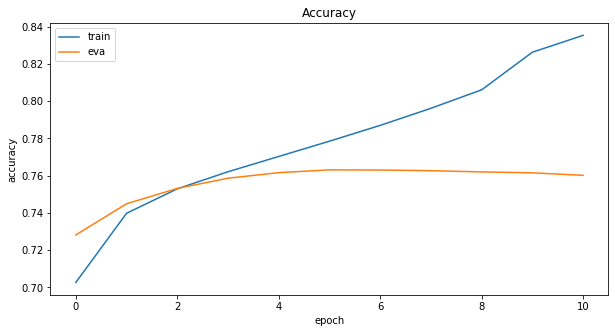

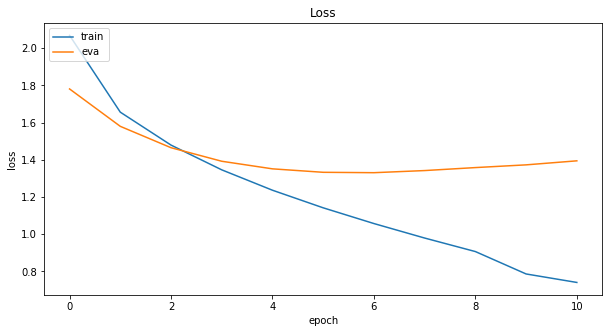

In [40]:
print("Now, we start drawing the loss and acc trends graph...")  
    
# Summarize history for accuracy 
fig = plt.figure(figsize=(10,5))
plt.plot(history.history["acc"])  
plt.plot(history.history["val_acc"])  
plt.title("Accuracy")  
plt.ylabel("accuracy")  
plt.xlabel("epoch")  
plt.legend(["train","eva"],loc="upper left")  
plt.show()
    
# Summarize history for loss
fig = plt.figure(figsize=(10,5))     
plt.plot(history.history["loss"])  
plt.plot(history.history["val_loss"])  
plt.title("Loss")  
plt.ylabel("loss")  
plt.xlabel("epoch")  
plt.legend(["train","eva"],loc="upper left")  
plt.show()

### 5.5 Learning Rate

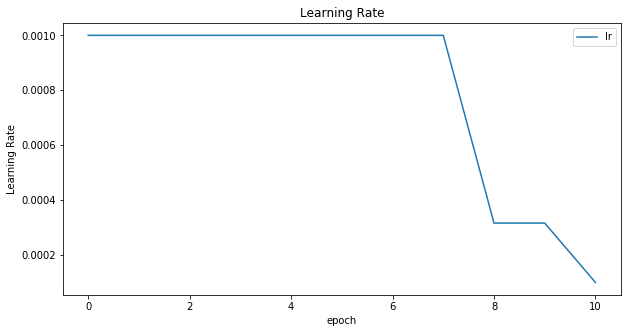

In [41]:
#summarize history for Learning rate
fig = plt.figure(figsize=(10,5))     
plt.plot(history_lr, label="lr")
plt.title("Learning Rate")  
plt.ylabel("Learning Rate")  
plt.xlabel("epoch")  
plt.legend()  
plt.show()


## 6. Translate Samples

In [42]:
import pandas as pd
df = pd.read_csv('./data/cmn.txt',sep='\t', header=None, names = ['en','cn'])
df.head()

,en,cn
0,Hi.,嗨。
1,Hi.,你好。
2,Run.,你用跑的。
3,Wait!,等等！
4,Hello!,你好。


In [43]:
def _init_states(enc_model, src_sentence, tokenizers, src_max_len):
    """generate the states from encoder
    Args:
        enc_model
        src_sentence
        tokenizers: tuple (src_tokenizer, tar_tokenizer)
        src_max_len
    Return:
        tuple (target_triple, initial_states)
    """
    src_tokenizer, tar_tokenizer = tokenizers
    src_index_word = src_tokenizer.index_word
    src_word_index = src_tokenizer.word_index 
    tar_index_word = tar_tokenizer.index_word
    tar_word_index = tar_tokenizer.word_index
    tar_token = '<s>'
    tar_index = tar_word_index.get(tar_token, None)
    if tar_index == None:
        print('start token <s> not found!')
    src_input_seq = src_tokenizer.texts_to_sequences([src_sentence])
    src_input_seq = pad_sequences(src_input_seq, maxlen=src_max_len, padding='post')
    states = enc_model.predict(src_input_seq)
    return ([tar_index], [tar_token], [1.0]), states

In [44]:
def _update_states(dec_model, tar_triple, states, tokenizers):
    """ update the decoder states
    Args:
        dec_model
        tar_triple: (target index[list], target_token[list], target_probability[list])
        states:
        params:
    Return:
        tuple (tar_triple, states)
    """
    src_tokenizer, tar_tokenizer = tokenizers
    src_index_word = src_tokenizer.index_word
    src_word_index = src_tokenizer.word_index 
    tar_index_word = tar_tokenizer.index_word
    tar_word_index = tar_tokenizer.word_index
    tar_index, tar_token, tar_prob = tar_triple
    # predict the token probability, and states
    probs, state_h, state_c = dec_model.predict([[tar_index[-1]]] + states)
    states_new = [state_h, state_c]
    # update the triple
    # greedy search: each time find the most likely token (last position in the sequence)
    probs = probs[0,-1,:]
    tar_index_new = np.argmax(probs)
    tar_token_new = tar_index_word.get(tar_index_new, None)
    tar_prob_new = probs[tar_index_new]
    tar_triple_new = ( 
        tar_index + [tar_index_new],
        tar_token + [tar_token_new],
        tar_prob + [tar_prob_new]
        )
    return tar_triple_new, states_new

In [45]:
def infer_lstm(src_sentence, enc_model, dec_model, tokenizers, max_len = (9,14)):
    """infer the seq2seq model
    Args:
        src_sentence
        enc_model
        dec_model
        tokenizers,
        max_len
    Return:
        decoded sentence
    """
    src_max_len, tar_max_len = max_len
    # initialize with encoder states
    tr, ss = _init_states(enc_model, src_sentence, tokenizers, src_max_len)
    for i in range(tar_max_len):
        # update the triple and states
        tr, ss = _update_states(dec_model, tr, ss, tokenizers)
        if tr[1][-1] == '<e>' or tr[1][-1] == None:
            break
    return ''.join(tr[1])

In [46]:
for i in range(700,710):
    src_raw = en_test[i]
    #src_raw = df.en.values[i]
    src = clean_eng(src_raw)
    #print("src:", src)
    #src = "And we really have this incredibly simplistic view of why people work and what the labor market looks like."
    #dec = infer_lstm(src, enc_model, dec_model, (src_tokenizer, tar_tokenizer),(50,49))
    #print('[%s] => [%s]'%(src,dec))

In [47]:
print("Everything seems OK...")
print("Accomplished!")

Everything seems OK...
Accomplished!
